In [49]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.gen_tables.search_best_inter as search_inter

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv') 
GRAPH_PATH = os.path.join(HOME, 'data/graphs')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Seq

In [114]:
# run python scripts to generate all the pickles needed
gen_seq = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_seq.py')   
%run $gen_seq 

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
print(df_seq.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'tot_runtime',
       'stall_icnt_to_l2', 'stall_l2_to_icnt', 'stall_core_ldst',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'l2_total_accesses', 'mem_count', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn',
       'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy', 'runtime',
       'instructions', 'l2_bw', 'barrier_cycles', 'inst_empty_cycles',
       'branch_cycles', 'scoreboard_cycles', 'stall_sp_cycles',
       'stall_dp_cycles', 'stall_int_cycles', 'stall_tensor_cycles',
       'stall_sfu_cycles', 'stall_mem_cycles', 'not_selected_cycles',
       'cycles_per_issue', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'dram_eff', 'dram_bw', 'row_buffer_locality',
       'mem_idle', 'total_cmd', 'ipc', 'avg_dram_bw', 'avg_dram_eff',
       'avg_row_locality', 'std_dram_bw', 'ratio_dram_bw', 'MPKI',
       'l2_acc

In [115]:
# Massage the table for Latex
df_seq['DRAM BW Util(%)'] = df_seq['avg_dram_bw'] * 100


In [117]:
col_seq = ['pair_str', 
           'waves',
           'runtime', #'instructions', 
#            'ipc',
           'DRAM BW Util(%)', 
           'l2_miss_rate', 
           'MPKI',
#            'l2_bw',
#            'avg_core_to_l2', 
           'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy',
           'not_selected_cycles'
          ]
df_seq.sort_values('pair_str', inplace=True)
df_seq.reset_index(inplace=True, drop=True)
draw_table(df_seq, col_seq, False).format(
    {'avg_dram_bw':'{:.4f}', 
     'ratio_dram_bw': '{:.2f}',
     'DRAM BW Util(%)': '{:.3f}',
     'sp_busy': '{:.2f}',
     'dp_busy': '{:.2f}',
     'int_busy': '{:.2f}',
     'tensor_busy': '{:.2f}',
     'sfu_busy': '{:.2f}',
     'waves': '{:.2f}',
     'l2_total_accesses': '{:,}',
     'l2_access_density': '{:.1f}',
     'instructions': '{:,}',
     'runtime': '{:,}',
    })

,pair_str,waves,runtime,DRAM BW Util(%),l2_miss_rate,MPKI,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy,not_selected_cycles
0,cut_sgemm-0,0.80,"97,339",3.881,0.5466,1.25812,0.14,0.00,0.07,0.00,0.00,1.52
1,cut_sgemm-1,3.20,"1,280,717",7.724,0.2574,0.371142,0.33,0.00,0.14,0.00,0.00,1.59
2,cut_wmma-0,0.40,"60,681",0.021,0.1275,1.81047,0.00,0.00,0.05,0.21,0.00,0.99
3,cut_wmma-2,3.20,"754,938",9.937,0.1493,1.75941,0.00,0.00,0.11,0.55,0.00,1.12
4,nvd_binomial-0,0.80,"1,442,650",0.002,0.0926,0.00030533,0.36,0.00,0.04,0.00,0.00,3.76
5,nvd_blackscholes-0,12.21,"132,103",75.503,0.9987,8.56201,0.14,0.00,0.03,0.00,0.15,1.34
6,nvd_fdtd3d-0,3.60,"2,704,051",22.148,0.6514,5.04449,0.05,0.00,0.02,0.00,0.00,1.07
7,nvd_interval-0,1.07,"72,729",0.006,0.7369,2.10933,0.00,0.25,0.03,0.00,0.26,1.27
8,nvd_sobol-0,20.00,"114,292",38.372,0.9729,1.81067,0.02,0.00,0.48,0.00,0.00,5.13
9,parb_cutcp-0,0.09,"802,931",0.001,0.0428,0.0169165,0.04,0.00,0.01,0.00,0.02,1.03


In [98]:
df_seq.to_latex(index=False, float_format="%.2f", columns=col_seq, bold_rows=True, 
                buf=os.path.join(HOME, 'data/latex/workloads.tex'))

# Intra

In [118]:
gen_intra = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_intra.py')
%run $gen_intra

In [119]:
df_intra = pd.read_pickle(os.path.join(PKL_PATH, 'intra.pkl'))
print(df_intra.shape)
col_intra = ['pair_str', 'intra', 'norm_ipc']

# draw_table(df_intra, col_intra)

(128, 68)


In [120]:
df_intra_best = pd.read_pickle(os.path.join(PKL_PATH, 'intra_best.pkl'))
df_intra_best.sort_values('pair_str', inplace=True)
col_intra_best = ['pair_str', 
        'perfdollar', 'intra', 'norm_ipc', 
        'runtime',
        'l2_miss_rate',
        #'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
        'comp_busy', 'dram_busy', 'avg_dram_bw', 'avg_dram_eff', 'bypass_l2']

draw_table(df_intra_best, col_intra_best).format({'norm_ipc': "{:.4f}", 'dominant_resc': '{:.2f}'})

pair_str,perfdollar,intra,norm_ipc,runtime,l2_miss_rate,comp_busy,dram_busy,avg_dram_bw,avg_dram_eff,bypass_l2
cut_sgemm-0,1.04918,2,1.0000,97339,0.5466,0.252273,0.0866736,0.0388125,0.370753,0
cut_sgemm-1,1.04918,2,1.0000,1280717,0.2574,0.666143,0.159611,0.0772369,0.449188,0
cut_wmma-0,2.00784,2,1.0000,60681,0.1275,0.0607882,0.000742055,0.000213994,0.131598,0
cut_wmma-2,1.31131,3,0.9796,770629,0.1628,0.166503,0.221867,0.1124,0.272872,0
nvd_binomial-0,2.67641,5,0.8364,1724879,0.0926,0.415586,7.58097e-05,2.04612e-05,0.118584,0
nvd_blackscholes-0,2.45211,6,0.9195,143662,0.0125,0.201515,0.941288,0.7242,0.765584,1
nvd_fdtd3d-0,1.6,1,1.0000,2704051,0.6514,0.145459,0.728195,0.221481,0.268378,0
nvd_interval-0,2.70755,4,0.8461,85957,0.8358,0.127891,0.000220292,5.32463e-05,0.100981,0
nvd_sobol-0,1.36211,20,0.8513,134253,0.0125,0.599089,0.609851,0.394581,0.533719,1
parb_cutcp-0,8,2,1.0000,802931,0.0428,0.0843149,3.90295e-05,1.02633e-05,0.100289,0


In [121]:
df_bi = df_intra[df_intra['pair_str'] == 'nvd_binomial-0'].sort_values('intra')

draw_table(df_bi, col_intra)

pair_str,intra,norm_ipc
nvd_binomial-0,1,0.215982
nvd_binomial-0,2,0.395514
nvd_binomial-0,3,0.546862
nvd_binomial-0,4,0.667374
nvd_binomial-0,5,0.836378
nvd_binomial-0,6,0.817797
nvd_binomial-0,7,1.0061
nvd_binomial-0,8,1.0193
nvd_binomial-0,9,1.01371
nvd_binomial-0,10,1.00211


# Find intra pairs

In [81]:
col_prod = ['norm_ipc_x', 'norm_ipc_y', 'diff_mflat', 'sum_ipc', 
            'intra_x', 'intra_y', 
           'sum_comp', 'sum_dram', 'penalized', 'config', 'l2_miss_rate_x', 'l2_miss_rate_y']
find_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_pair_configs.py')


app1 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 1:',
    disabled=False
)

app2 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 2:',
    disabled=False
)

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

intra_out = widgets.Output()

def onclick(b):
    intra_out.clear_output()
    
    with intra_out:
        %run $find_pair --app $app1.value $app2.value --qos $qos.value

        pair_pickle_path = os.path.join(PKL_PATH, 'pair_candidates.pkl')
        if os.path.exists(pair_pickle_path):
            df_prod = pd.read_pickle(pair_pickle_path)
            display(HTML(draw_table(df_prod, col_prod, False).render()))

        
button.on_click(onclick)
widgets.VBox([app1, app2, qos, button, intra_out])

In [86]:
sum_jobs = 0
sum_feasible_pairs = 0
sum_checked_pairs = 0
arr_jobs = []

intra_pkl_path = os.path.join(PKL_PATH, 'intra.pkl')
benchmarks = [b for b in const.kernel_yaml.keys() if b not in const.multi_kernel_app]

for bench1 in benchmarks:
    for bench2 in benchmarks:
        if bench1 < bench2:
            bench1_name = bench1.split('-')[0]
            bench2_name = bench2.split('-')[0]
            if bench1_name != bench2_name:
                sum_checked_pairs += 1
                feasible = len(gen_pair.build_df_prod(intra_pkl_path, 0.5, [bench1, bench2], 2.5, top_only=False).index)
                if feasible > 0:
                    arr_jobs.append((bench1, bench2))
                    sum_feasible_pairs += 1
                    sum_jobs += feasible
                
print('=== Intra-SM Pair Jobs ===')
print('Number of checked pairs: ', sum_checked_pairs) 
print('Number of feasible pairs: ', sum_feasible_pairs)
print('Number of jobs: ', sum_jobs)

Error. No feasible pair configs for ('cut_sgemm-1', 1)+('nvd_fdtd3d-0', 1) at QoS 0.5.
Error. No feasible pair configs for ('cut_sgemm-0', 1)+('nvd_fdtd3d-0', 1) at QoS 0.5.
Error. No feasible pair configs for ('cut_wmma-2', 1)+('nvd_fdtd3d-0', 1) at QoS 0.5.
=== Intra-SM Pair Jobs ===
Number of checked pairs:  169
Number of feasible pairs:  166
Number of jobs:  1198


In [58]:
# Find what's missing in pair_intra
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
df_bench = df_dynamic[['1_bench', '2_bench']]
arr_pair = [tuple(x) for x in df_bench.to_numpy()]
arr_pair = list(dict.fromkeys(arr_pair))
print(len(arr_pair))

diff = set(arr_jobs) - set(arr_pair)
print(list(diff))

134
[('cut_wmma-0', 'nvd_sobol-0')]


# Inter

In [107]:
gen_inter = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_inter.py')
%run $gen_inter

In [108]:
df_inter = pd.read_pickle(os.path.join(PKL_PATH, 'inter.pkl'))
print(len(df_inter['pair_str'].unique()))
print(df_inter[df_inter['inter'] == 80][['pair_str', 'norm_ipc']])

19
                pair_str  norm_ipc
8         nvd_binomial-0  1.000000
18         rod_hotspot-0  1.000000
28           parb_spmv-0  1.000000
38       rod_hotspot3d-0  1.000000
40           nvd_sobol-0  0.952489
58           cut_sgemm-0  1.000000
68            cut_wmma-2  1.000000
78        nvd_interval-0  1.000000
88          rod_lavamd-0  1.000000
98      rod_pathfinder-0  1.000000
108           cut_wmma-0  1.000000
118      rod_heartwall-0  1.000000
120   nvd_blackscholes-0  0.715350
138         nvd_fdtd3d-0  1.000000
148       parb_stencil-0  1.000000
150           parb_lbm-0  0.510291
160  rod_streamcluster-0  1.004350
178         parb_cutcp-0  1.000000
188          cut_sgemm-1  1.000000


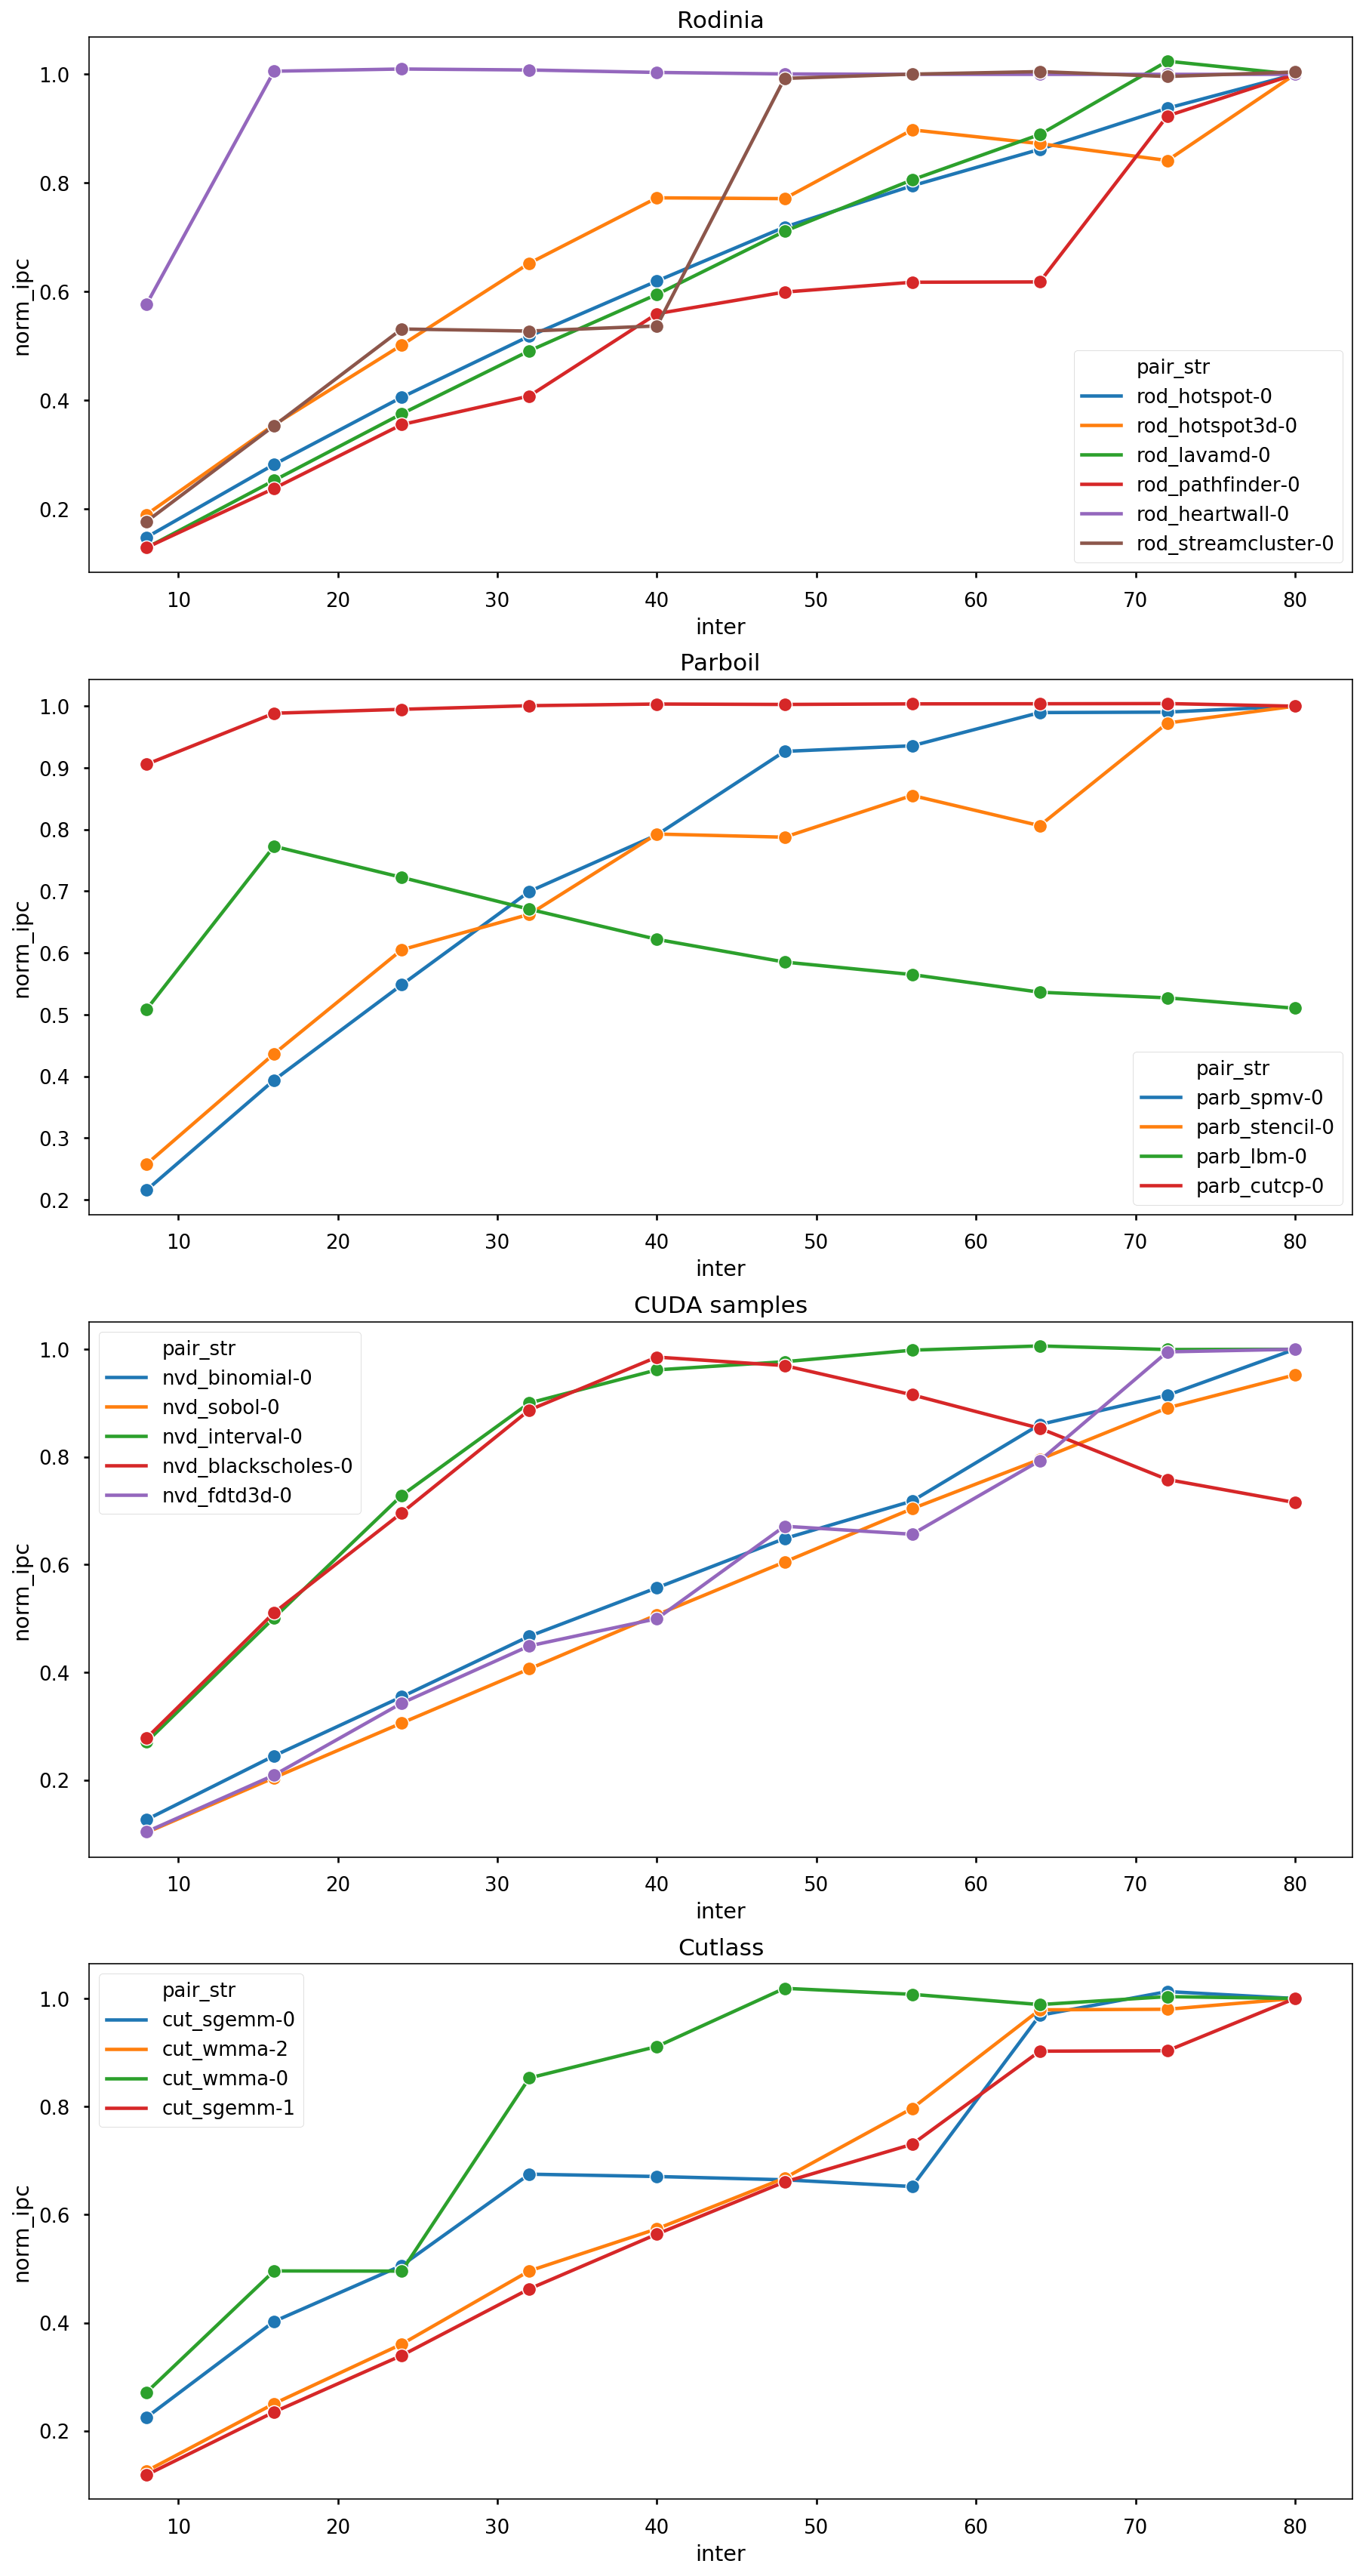

In [109]:
# Show runtime v.s. # of SMs
f, axs = plt.subplots(4,1,figsize=(15, 30))
plt.subplot(411)
data = df_inter[df_inter['pair_str'].str.contains('rod_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Rodinia')

plt.subplot(412)
data = df_inter[df_inter['pair_str'].str.contains('parb_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Parboil')

plt.subplot(413)
data = df_inter[df_inter['pair_str'].str.contains('nvd_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('CUDA samples')

plt.subplot(414)
data = df_inter[df_inter['pair_str'].str.contains('cut_')]
sns.lineplot(x = "inter", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Cutlass')

plt.savefig(os.path.join(GRAPH_PATH, 'sm-sensitivity.pdf'), bbox_inches='tight')

In [110]:
# Show runtime v.s. number of thread block waves
def calc_wave(row):
    return const.app_dict[row['pair_str']][1] / (const.app_dict[row['pair_str']][0] * row['inter'])

df_inter['waves'] = df_inter.apply(lambda row: calc_wave(row), axis=1)

# divide kernels based on min waves
df_groupby = df_inter[['pair_str', 'waves']].groupby(['pair_str']).min()
lt_one = df_groupby[df_groupby['waves'] < 1].index.to_list()
gt_one = df_groupby[df_groupby['waves'] >= 1].index.to_list()

AttributeError: ("module 'data.scripts.common.constants' has no attribute 'app_dict'", 'occurred at index 0')

In [ ]:
f, axs = plt.subplots(2,1,figsize=(15, 30))
plt.subplot(411)
good_intra = ['rod_lavamd-0', 'nvd_interval-0']
data = df_inter[df_inter['pair_str'].isin(good_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Good intra')

plt.subplot(412)
ok_intra = ['nvd_fdtd3d-0', 'nvd_sobol-0', 'cut_sgemm-1', 'nvd_interval-0', 'parb_spmv-0', 'rod_hotspot3d-0']
data = df_inter[df_inter['pair_str'].isin(ok_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
# plt.xlim([0, 2])
plt.title('OK intra')

plt.subplot(413)
meh_intra = ['cut_wmma-0', 'parb_stencil-0', 'nvd_blackscholes-0', 'rod_hotspot-0', 'parb_lbm-0']
data = df_inter[df_inter['pair_str'].isin(meh_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.title('Meh intra')

plt.subplot(414)
bad_intra = ['parb_cutcp-0', 'rod_heartwall-0', 'rod_streamcluster-0']
data = df_inter[df_inter['pair_str'].isin(bad_intra)]
sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
plt.xlim([0, 2])
plt.title('Bad intra')

# plt.subplot(414)
# data = df_inter[df_inter['pair_str'].str.contains('cut_')]
# sns.lineplot(x = "waves", y = "norm_ipc", hue="pair_str", data=data, marker='o')
# plt.title('Cutlass')

# plt.savefig(os.path.join(GRAPH_PATH, 'sm-sensitivity.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
app1 = widgets.Dropdown(
    options=df_inter['pair_str'].unique(),
    value='cut_sgemm-1',
    rows=5,
    description='App 1:',
    disabled=False
)

app2 = widgets.Dropdown(
    options=df_inter['pair_str'].unique(),
    value='cut_sgemm-1',
    rows=5,
    description='App 2:',
    disabled=False
)

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

def show_widgets():
    display(app1)
    display(app2)
#     display(qos)
    display(button)
    
show_widgets()

def onclick(b):
    clear_output()
    show_widgets()

#     df_a1 = df_inter[df_inter['pair_str'] == app1.value].copy()
#     df_a1['key'] = 0
#     df_a2 = df_inter[df_inter['pair_str'] == app2.value].copy()
#     df_a2['key'] = 0
    
#     df_prod = df_a1.merge(df_a2, how='outer', on='key')
#     df_prod.drop(columns=['key'])
#     df_prod['inter_sum'] = df_prod['inter_x'] + df_prod['inter_y']
#     df_prod['norm_ipc_sum'] = df_prod['norm_ipc_x'] + df_prod['norm_ipc_y']
    
#     df_prod = df_prod[df_prod['inter_sum'] == 80]
#     df_prod.sort_values('inter_x', inplace=True, ascending=True)
    col_prod_inter = ['pair_str_x', 'pair_str_y', 'inter_x', 'inter_y', 'inter_sum',
                      'norm_ipc_x', 'norm_ipc_y', 'norm_ipc_sum', 'config']

    find_inter_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_inter_configs.py')
    %run $find_inter_pair --app $app1.value $app2.value
    
    df_prod = pd.read_pickle(os.path.join(PKL_PATH, 'inter_candidates.pkl'))
    
    sns.lineplot(x='inter_x', y='norm_ipc_sum', data=df_prod, marker='o')
    plt.show()
    display(HTML(draw_table(df_prod, col_prod_inter).render()))
    
    
button.on_click(onclick)

In [131]:
sum_jobs = 0
sum_feasible_pairs = 0
sum_checked_pairs = 0
arr_jobs = []

inter_pkl_path = os.path.join(PKL_PATH, 'inter.pkl')
pair_inter_pkl_path = os.path.join(PKL_PATH, 'pair_inter.pkl')

for bench1 in const.app_for_pair:
    for bench2 in const.app_for_pair:
        if bench1 < bench2:
            sum_checked_pairs += 1
            feasible = len(search_inter.build_configs_local(inter_pkl_path, pair_inter_pkl_path, [bench1, bench2], 2))
            if feasible > 0:
                arr_jobs.append((bench1, bench2))
                sum_feasible_pairs += 1
                sum_jobs += feasible
                
print('=== Inter-SM Pair Jobs ===')
print('Number of checked pairs: ', sum_checked_pairs) 
print('Number of feasible pairs: ', sum_feasible_pairs)
print('Number of jobs: ', sum_jobs)

=== Inter-SM Pair Jobs ===
Number of checked pairs:  136
Number of feasible pairs:  5
Number of jobs:  5
